# TP2: Regresión del valor de valor medio de casas en distritos de California

## Integrantes

- Nicolás Rodriguez da Cruz
- Francisco Cofré
- Gaspar Acevedo Zain
- Juan Chunga
- Rodrigo Nicolás Lauro

### Imports y carga del dataset

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [3]:
# Cargamos el dataset - Código provisto por la cátedras
california_housing = fetch_california_housing()

# Obtenemos los atributos y el target:
X = california_housing.data
y = california_housing.target

# Transformamos los datos a estructuras de Pandas:
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos X e y; esto es útil para generar el mapa de calor de correlaciones
df_california = pd.concat([X, y], axis=1)

In [4]:
# Vemos una descripción general del dataset
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### 1. Obtener la correlación entre los atributos y entre los atributos y el target

1. ¿Qué atributo tiene mayor correlación lineal con el target?
1. ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden calcular los coeficientes de correlación o representarlos gráficamente mediante un mapa de calor.

#### 1.1 ¿Qué atributo tiene mayor correlación lineal con el target?

Mediante la función `corr`, obtenemos la correlación entre todas las variables del dataset, incluyendo el target `MedHouseVal`.

La única variable que tiene un valo de correlación alto con el target `MedHouseVal` es:
- `MedInc`, cuyo valor de correlación es $0.688075 \approx 0,69$

El resto de las variables presentan valores bajos (cercanos a ***cero***) de correlación con el target `MedHouseVal`, variando entre $-0.144160 \approx -0.14$ (variable `Latitude`) y $0.151948 \approx 0.15$ (variable `AveRooms`)

#### 1.2 ¿Cuáles atributos parecen estar más correlacionados entre sí?

Mediante la misma función `corr`, obtenemos la correlación entre todas las variables del dataset, incluyendo el target `MedHouseVal`.

La siguiente tabla muestra la correlación de algunas variables del dataframe, ordenandolas por valor absoluto de forma decreciente:

| Variable 01 | Variable 02 | Valor de Correlación |
|---|---|---|
| Longitude | Latitude | $-0.924664 \approx -0.92$|
| AveBedrms | AveRooms | $0.847621 \approx 0.85$|
| AveRooms | MedInc | $0.326895 \approx 0.33$ |
| Population | HouseAge | $-0.296244 \approx -0.30$|

Como se puede observar, las variables `Longitud` y `Latitude` tiene una alta correlación negativa, cuyo valor es $-0.924664 \approx -0.92$. Esto indica que, a medida que los valores de una de esta variable ***crece***, el otro ***decrece***.
Por otro lado, `AveBedrms` y `AveRooms` tienen una alta correlación, con un valor de $0.847621 \approx 0.85$. Esto indica que, a medida que los valores de una de esta variable ***crece***, el otro también ***crece***.

Los otros dos casos listados presentan un valor de correlación relativamente bajo en valor absoluto:
- $0.326895 \approx 0.33$ para `AveRooms` y `MedInc`
- $-0.296244 \approx -0.30$ para `Population` y `HouseAge`

El resto de los casos no los listamos, ya que presentan valores cercanos a cero, es decir, *no hay correlación*.

#### Código y gráficas para resolución de ejercicio 1

In [5]:
# Obtenemos la correlación entre todas las variables del dataframe, incluyendo el target (MedHouseVal)
df_california.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


<Axes: >

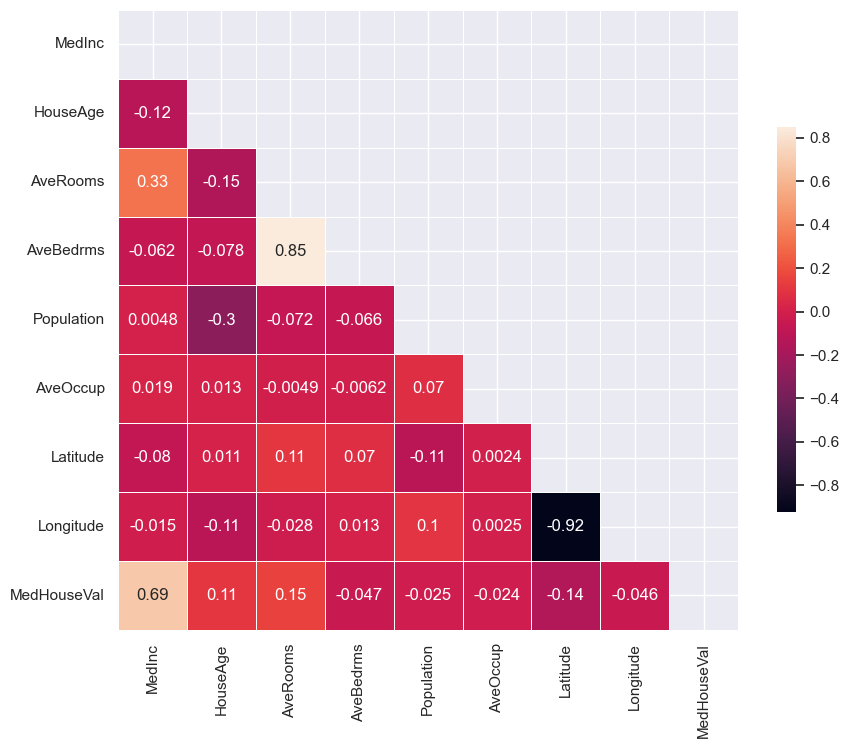

In [35]:
# Fuente: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df_california.corr()

# Se genera una máscara para la parte correspondiente al triángulo superior de la matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# Tamaño del gráfico de matplotlib
plt.figure(figsize=(10, 10))

sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2. Graficar los histogramas de los distintos atributos y del target.

1. ¿Qué forma presentan los histogramas?
1. ¿Alguno muestra una distribución similar a una campana que sugiera una distribución gaussiana, sin necesidad de realizar pruebas de hipótesis?

### 3. Calcular una regresión lineal utilizando todos los atributos.
1. Con el conjunto de entrenamiento, calcular la varianza total del modelo y la varianza explicada por el modelo.
1. ¿Está el modelo capturando adecuadamente el comportamiento del target? Fundamente su respuesta.

### 4. Calcular las métricas de MSE, MAE y R² sobre el conjunto de evaluación.

### 5. Crear una regresión de Ridge

1. Usar validación cruzada de 5 folds y tomar como métrica el MSE.
1. Buscar el mejor valor de α en el rango [0, 12.5].
1. Graficar el MSE en función de α.

### 6. Comparar los resultados obtenidos entre la regresión lineal y la mejor regresión de Ridge, evaluando el conjunto de prueba

1. ¿Cuál de los dos modelos obtiene mejores resultados en términos de MSE y MAE? ¿Poseen suficiente diferencia como para indicar si uno es mejor que el otro?
1. ¿Qué tipo de error podría haberse reducido?